In [1]:
# !pip install --extra-index-url https://rospypi.github.io/simple/ rospy rosbag


Looking in indexes: https://pypi.org/simple, https://rospypi.github.io/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.7/116.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 8.6 MB/s eta 0:00:00
  Created wheel for gnupg: filename=gnupg-2.3.1-py3-none-any.whl size=94617 sha256=fa741fd56bcd4baab79ac480447e5a9b56eff443cb8a812f01dc10c98b4fb4d0
  Stored i

In [2]:
import rosbag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import csv

The Subset Data file can be dowloaded from 
https://drive.google.com/file/d/1yQOHsNhCSzO-3Pm-Yl0G4PalztfZD1XS/view?usp=drive_link

In [28]:
path = "/content/drive/MyDrive/Colab Notebooks/subset.bag"
bag = rosbag.Bag(path)

In [29]:
for topic, msg, t in bag.read_messages():
  print(msg)
  break

header: 
  seq: 75061
  stamp: 
    secs: 1697739282
    nsecs: 763176357
  frame_id: "imu"
orientation: 
  x: -0.0003352643980178982
  y: -0.02734973281621933
  z: -0.0005908077582716942
  w: 0.9996256828308105
orientation_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
angular_velocity: 
  x: -0.0014820401556789875
  y: -0.0073815155774354935
  z: -0.0370248481631279
angular_velocity_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
linear_acceleration: 
  x: -0.5161187052726746
  y: 0.008187455125153065
  z: -9.526483535766602
linear_acceleration_covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [30]:
bag_path = "/content/drive/MyDrive/Colab Notebooks/subset.bag"

with rosbag.Bag(bag_path, 'r') as bag:
    with open('gps_data.csv', 'w', newline='') as gps_csv, \
         open('imu_data.csv', 'w', newline='') as imu_csv:

        gps_writer = csv.writer(gps_csv)
        imu_writer = csv.writer(imu_csv)

        gps_writer.writerow(['time', 'latitude', 'longitude'])
        imu_writer.writerow(['time', 'linear_acceleration.x', 'linear_acceleration.y', 'angular_velocity.z'])

        for topic, msg, t in bag.read_messages(topics=['/gps/fix', '/imu/imu_uncompensated']):
            if topic == '/gps/fix':
                gps_data = [t.to_sec(), msg.latitude, msg.longitude]
                gps_writer.writerow(gps_data)
            elif topic == '/imu/imu_uncompensated':
                imu_data = [t.to_sec(), msg.linear_acceleration.x, msg.linear_acceleration.y, msg.angular_velocity.z]
                imu_writer.writerow(imu_data)

print("CSV extraction complete.")


CSV extraction complete.


In [4]:
# gps_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gps_data.csv')
gps_data = pd.read_csv("gps_data.csv")
gps_data = gps_data[['latitude', 'longitude']].dropna().values

# imu_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/imu_data.csv')
imu_data = pd.read_csv("imu_data.csv")
imu_data = imu_data[['linear_acceleration.x', 'linear_acceleration.y', 'angular_velocity.z']].values

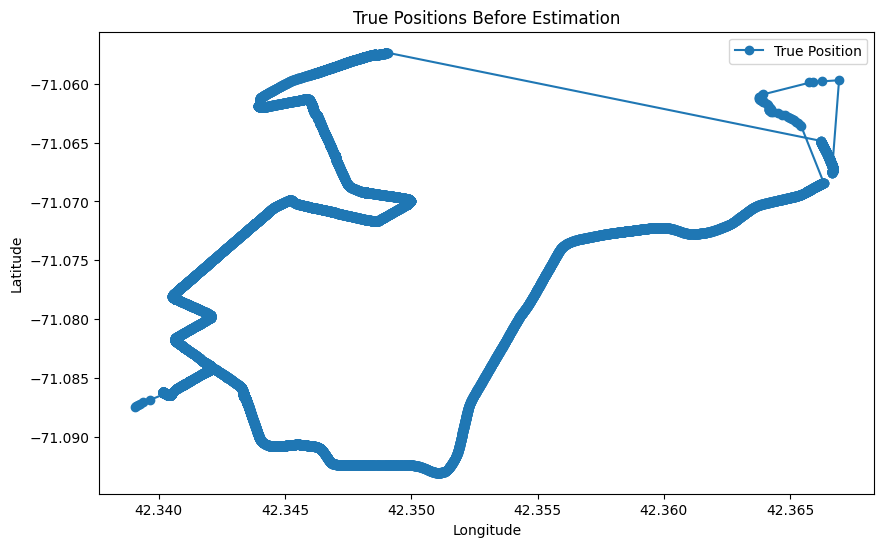

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gps_data[:, 0], gps_data[:, 1], label='True Position', marker='o')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('True Positions Before Estimation')
ax.legend()
plt.show()

In [6]:
def state_prediction(current_state, state_covariance, state_transition, process_noise):
    predicted_state = state_transition.dot(current_state)
    predicted_covariance = state_transition.dot(state_covariance).dot(state_transition.T) + process_noise
    return predicted_state, predicted_covariance

def measurement_correction(predicted_state, predicted_covariance, measurement, measurement_matrix, measurement_noise_covariance):
    kalman_gain = np.dot(np.dot(predicted_covariance, measurement_matrix.T), np.linalg.inv(np.dot(np.dot(measurement_matrix, predicted_covariance), measurement_matrix.T) + measurement_noise_covariance))
    measurement_residual = measurement - np.dot(measurement_matrix, predicted_state)
    state_update = np.dot(kalman_gain, measurement_residual)
    updated_state = predicted_state + state_update
    kalman_gain_matrix = np.dot(kalman_gain, measurement_matrix)
    covariance_update = np.dot(kalman_gain_matrix, predicted_covariance)
    updated_covariance = np.dot((np.eye(len(predicted_state)) - kalman_gain_matrix), predicted_covariance)
    return updated_state, updated_covariance

def kalman_filter(gps_data, imu_data):
    initial_state = np.array([gps_data[0, 0], gps_data[0, 1], 0])
    initial_covariance = np.eye(3) * 1e-4
    process_noise_covariance = np.eye(3) * 1e-4
    gps_measurement_noise_covariance = np.eye(2) * 1e-2
    imu_measurement_noise_covariance = np.eye(3) * 1e-2
    state_transition_matrix = np.eye(3)
    gps_measurement_matrix = np.array([[1, 0, 0], [0, 1, 0]])
    imu_measurement_matrix = np.array([[0, 0, 1], [0, 0, 0], [0, 0, 0]])
    x_hat = initial_state
    P = initial_covariance
    raw_gps = []
    dead_reck_pos = []
    kalman_est_pos = []

    for i in range(len(gps_data)):
        raw_gps.append(gps_data[i])
        if i == 0:
            dead_reck_pos.append(gps_data[i])
        else:
            dt = 1
            dead_reck_pos.append(dead_reck_pos[-1] + imu_data[i, :2] * dt)
        x_hat_minus, P_minus = state_prediction(x_hat, P, state_transition_matrix, process_noise_covariance)
        x_hat, P = measurement_correction(x_hat_minus, P_minus, gps_data[i], gps_measurement_matrix, gps_measurement_noise_covariance)
        x_hat, P = measurement_correction(x_hat, P, imu_data[i], imu_measurement_matrix, imu_measurement_noise_covariance)
        kalman_est_pos.append(x_hat.copy())
    raw_gps = np.array(raw_gps)
    dead_reck_pos = np.array(dead_reck_pos)
    kalman_est_pos = np.array(kalman_est_pos)
    return raw_gps, dead_reck_pos, kalman_est_pos

raw_gps, dead_reck_pos, kalman_est_pos = kalman_filter(gps_data, imu_data)

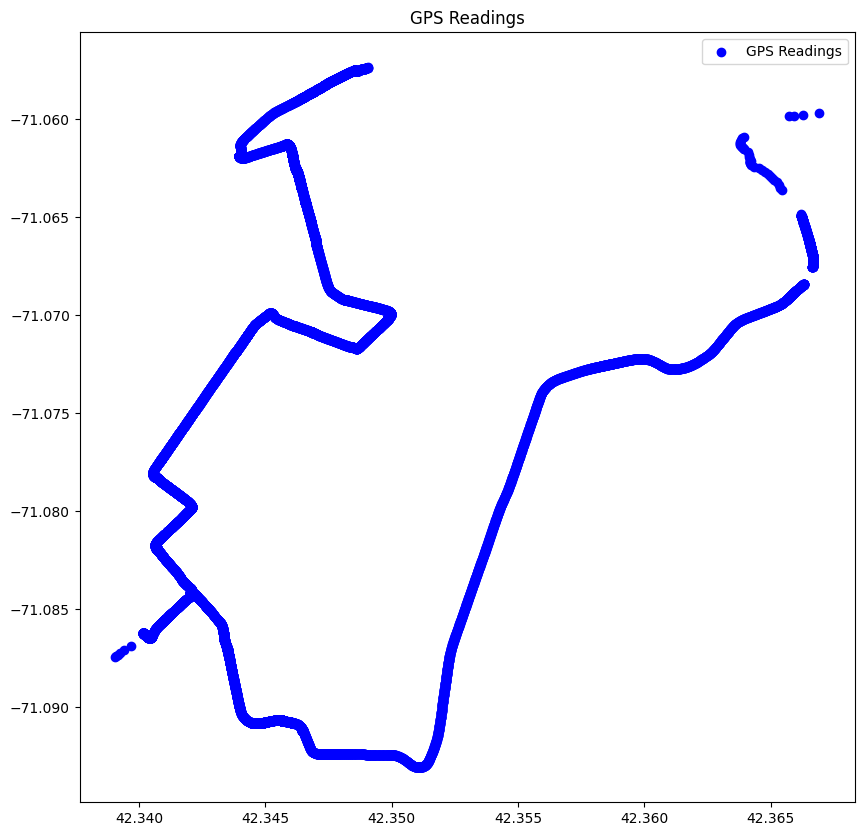

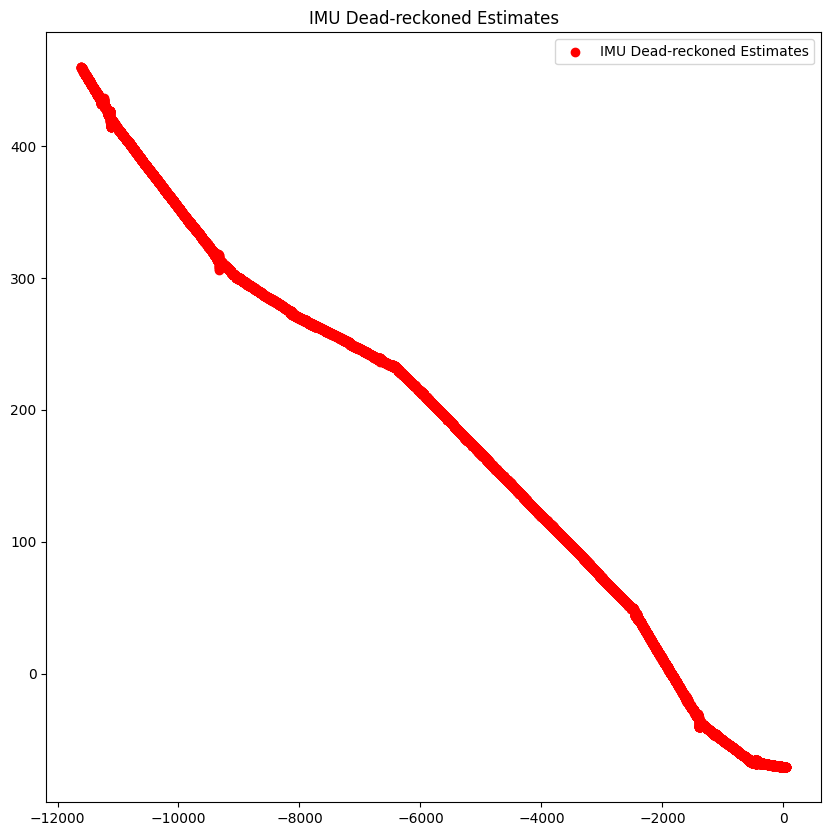

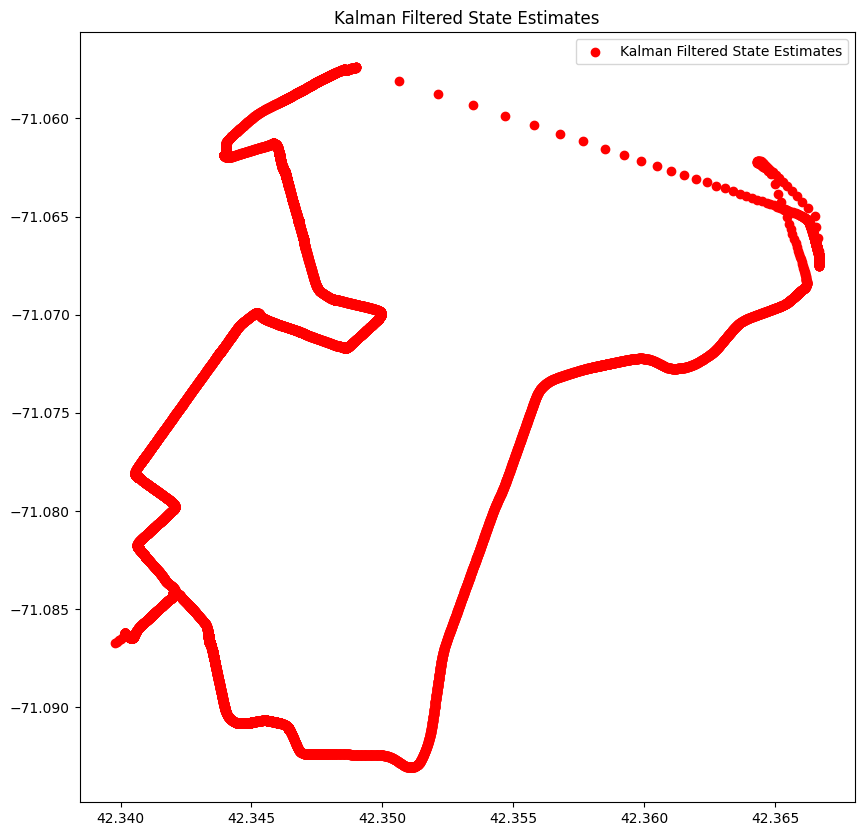

In [7]:
plt.figure(figsize=(10, 10))
plt.scatter(y=raw_gps[:, 1], x=raw_gps[:, 0], label='GPS Readings', color='blue')
plt.title('GPS Readings')
plt.legend()

plt.figure(figsize=(10, 10))
plt.scatter(y=dead_reck_pos[:, 1], x=dead_reck_pos[:, 0], label='IMU Dead-reckoned Estimates', color='red')
plt.title('IMU Dead-reckoned Estimates')
plt.legend()

plt.figure(figsize=(10, 10))
plt.scatter(y=kalman_est_pos[:, 1], x=kalman_est_pos[:, 0], label='Kalman Filtered State Estimates', color='red')
plt.title('Kalman Filtered State Estimates')
plt.legend()

plt.show()

In [8]:
def plot_on_map_plotly(raw_gps, dead_reck_pos, kalman_est_pos):
    raw_gps_df = pd.DataFrame(raw_gps, columns=["Latitude", "Longitude"])
    dead_reck_pos_df = pd.DataFrame(dead_reck_pos, columns=["Latitude", "Longitude"])
    kalman_est_pos_df = pd.DataFrame(kalman_est_pos, columns=["Latitude", "Longitude", "Location"])
    fig = px.scatter_mapbox(raw_gps_df, lat="Latitude", lon="Longitude", title="Raw GPS Readings", mapbox_style="open-street-map", zoom=15, hover_name="Latitude")
    fig.add_trace(px.scatter_mapbox(dead_reck_pos_df, lat="Latitude", lon="Longitude", title="Dead-reckoned IMU Estimates", mapbox_style="open-street-map", zoom=15, hover_name="Latitude").data[0])
    line_plot = px.line_mapbox(kalman_est_pos_df, lat="Latitude", lon="Longitude", title="Kalman Filtered State Estimates", mapbox_style="open-street-map", zoom=15, hover_name="Location")
    line_plot.data[0].line.color = "red"
    fig.add_trace(line_plot.data[0])
    fig.show()

plot_on_map_plotly(raw_gps, dead_reck_pos, kalman_est_pos)
